In [ ]:
from music21 import converter, instrument, note, chord, environment
'''from mingus.containers.note import Note
from mingus.containers.note_container import NoteContainer
from mingus.containers.bar import Bar
from mingus.containers.track import Track
from mingus.containers.composition import Composition
from mingus.containers.instrument import MidiInstrument
from mingus.midi import midi_file_in
import mingus.core.notes as notes
import mingus.core.intervals as intervals'''
import glob
import pandas as pd
import numpy as np
import pickle
from gan import GAN
from gan_music import *


# Instalamos MuseScore para visualizar la partitura

Indicamamos la ruta

In [2]:
environment.set("musescoreDirectPNGPath", "/Applications/MuseScore 4.app/Contents/MacOS/mscore")

# Cargamos los datos 

In [5]:
def get_notes(files):
    """Obtenemos todas las notas y acordes de cada archivo midi"""
    notes = []
    duration = []


    for file in files:
        midi = converter.parse(file)
        notes_to_parse = midi.flat.notes
        print("Parsing %s" % file)

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
                duration.append(element.duration.quarterLength)
            elif isinstance(element, chord.Chord):
                notes.append(' '.join(str(n) for n in element.pitches))
                duration.append(element.duration.quarterLength)

    return pd.DataFrame.from_dict({'pitch': notes, 'duration': duration}).drop_duplicates()

In [6]:
songs = glob.glob('dataset/**/*')
notes = get_notes(songs)

Parsing dataset/mozart/mz_570_1.mid
Parsing dataset/mozart/mz_570_2.mid
Parsing dataset/mozart/mz_570_3.mid
Parsing dataset/mozart/mz_545_1.mid
Parsing dataset/mozart/mz_332_3.mid
Parsing dataset/mozart/mz_330_1.mid
Parsing dataset/mozart/mz_332_2.mid
Parsing dataset/mozart/mz_545_2.mid
Parsing dataset/mozart/mz_330_2.mid
Parsing dataset/mozart/mz_330_3.mid
Parsing dataset/mozart/mz_332_1.mid
Parsing dataset/mozart/mz_545_3.mid
Parsing dataset/mozart/mz_331_2.mid
Parsing dataset/mozart/mz_333_1.mid
Parsing dataset/mozart/mz_331_3.mid
Parsing dataset/mozart/mz_331_1.mid
Parsing dataset/mozart/mz_333_3.mid
Parsing dataset/mozart/mz_333_2.mid
Parsing dataset/mozart/mz_311_1.mid
Parsing dataset/mozart/mz_311_2.mid
Parsing dataset/mozart/mz_311_3.mid
Parsing dataset/balakir/islamei.mid
Parsing dataset/liszt/liz_rhap09.mid
Parsing dataset/liszt/liz_et_trans8.mid
Parsing dataset/liszt/liz_donjuan.mid
Parsing dataset/liszt/liz_liebestraum.mid
Parsing dataset/liszt/liz_et2.mid
Parsing dataset/l

In [5]:
print('Number of files:', len(songs))
notes

Number of files: 262


,pitch,duration
0,B-4,2.0
1,B-3,2.0
2,F4,1.0
3,F3,1.0
4,D4,2.0
...,...,...
296290,C#4 F4 C#5 A4,1.0
296296,B-2,6.75
296332,C6 C5,1/3
296338,B-4 B-5,6.0


# Guardamos

Guardamos en un archivo el objeto notes para no procesarlo cada vez

In [7]:
with open('objects/notes.pickle', 'wb') as f:
    pickle.dump(notes, f)

### GAN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

/Users/karladsj/Documents/Semestre I/IA/Miausic/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 4ms/step
1 [D loss: 0.691020, acc.: 75.78%] [G loss: 0.691973]
2/2 [==============================] - 0s 3ms/step
2 [D loss: 0.690112, acc.: 67.97%] [G loss: 0.691626]
2/2 [==============================] - 0s 3ms/step
3 [D loss: 0.688593, acc.: 71.88%] [G loss: 0.691697]
2/2 [==============================] - 0s 1ms/step
4 [D loss: 0.688395, acc.: 66.41%] [G loss: 0.691186]
2/2 [==============================] - 0s 4ms/step
5 [D loss: 0.686983, acc.: 70.31%] [G loss: 0.690765]
2/2 [==============================] - 0s 2ms/step
6 [D loss: 0.686052, acc.: 69.53%] [G loss: 0.690609]
2/2 [==============================] - 0s 2ms/step
7 [D loss: 0.684343, acc.: 70.31%] [G loss: 0.690025]
2/2 [==============================] - 0s 2ms/step
8 [D loss: 0.682315, acc.: 80.47%] [G loss: 0.689051]
2/2 [==============================] - 0s 3ms/step
9 [D loss: 0.682507, acc.: 75.00%] [G loss: 0.688493]
2/2 [==============================] - 0s 2ms/step
10 [

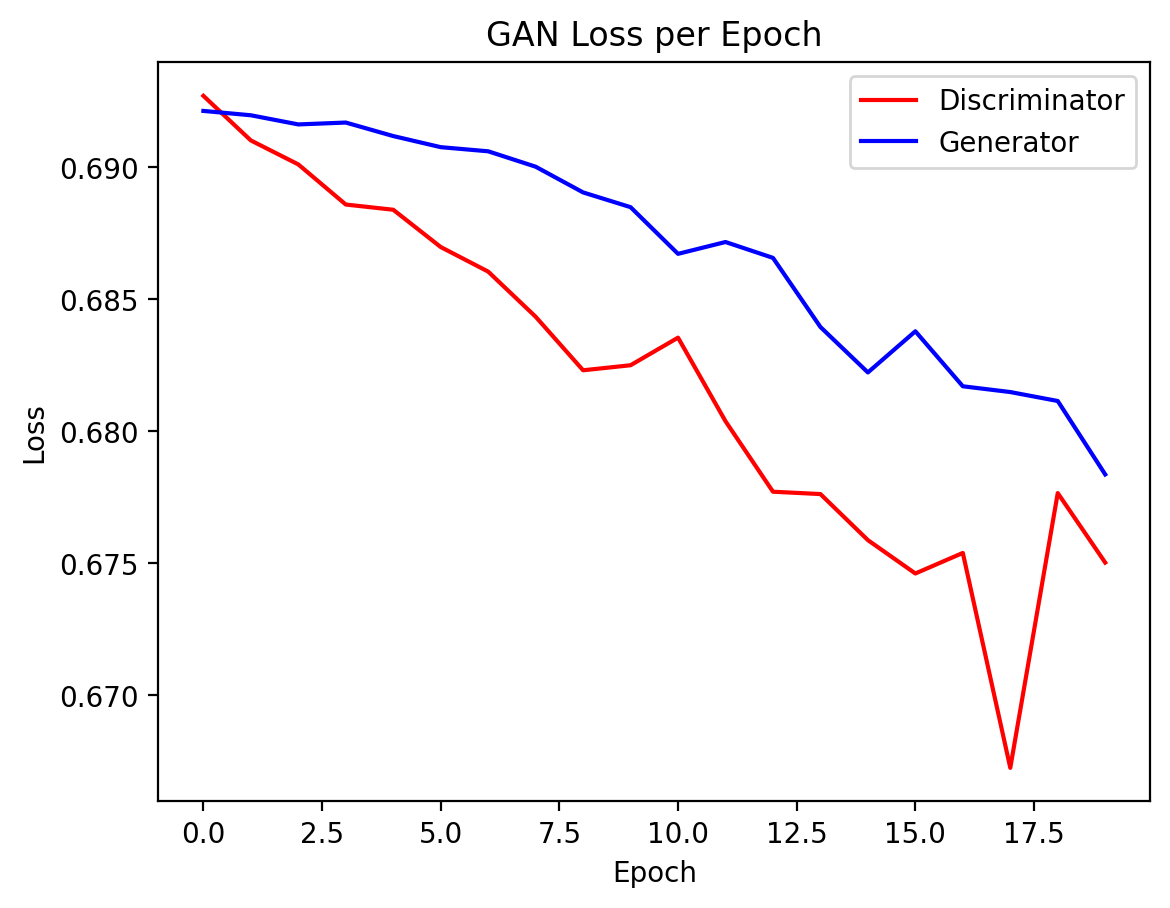

In [6]:
#pickle_file = open('objects/notes.pickle', 'rb')
#lista_fichero = pickle.load(pickle_file)
gan = GAN(notes)
gan.train()

# Generamos

1/1 [==============================] - 0s 101ms/step


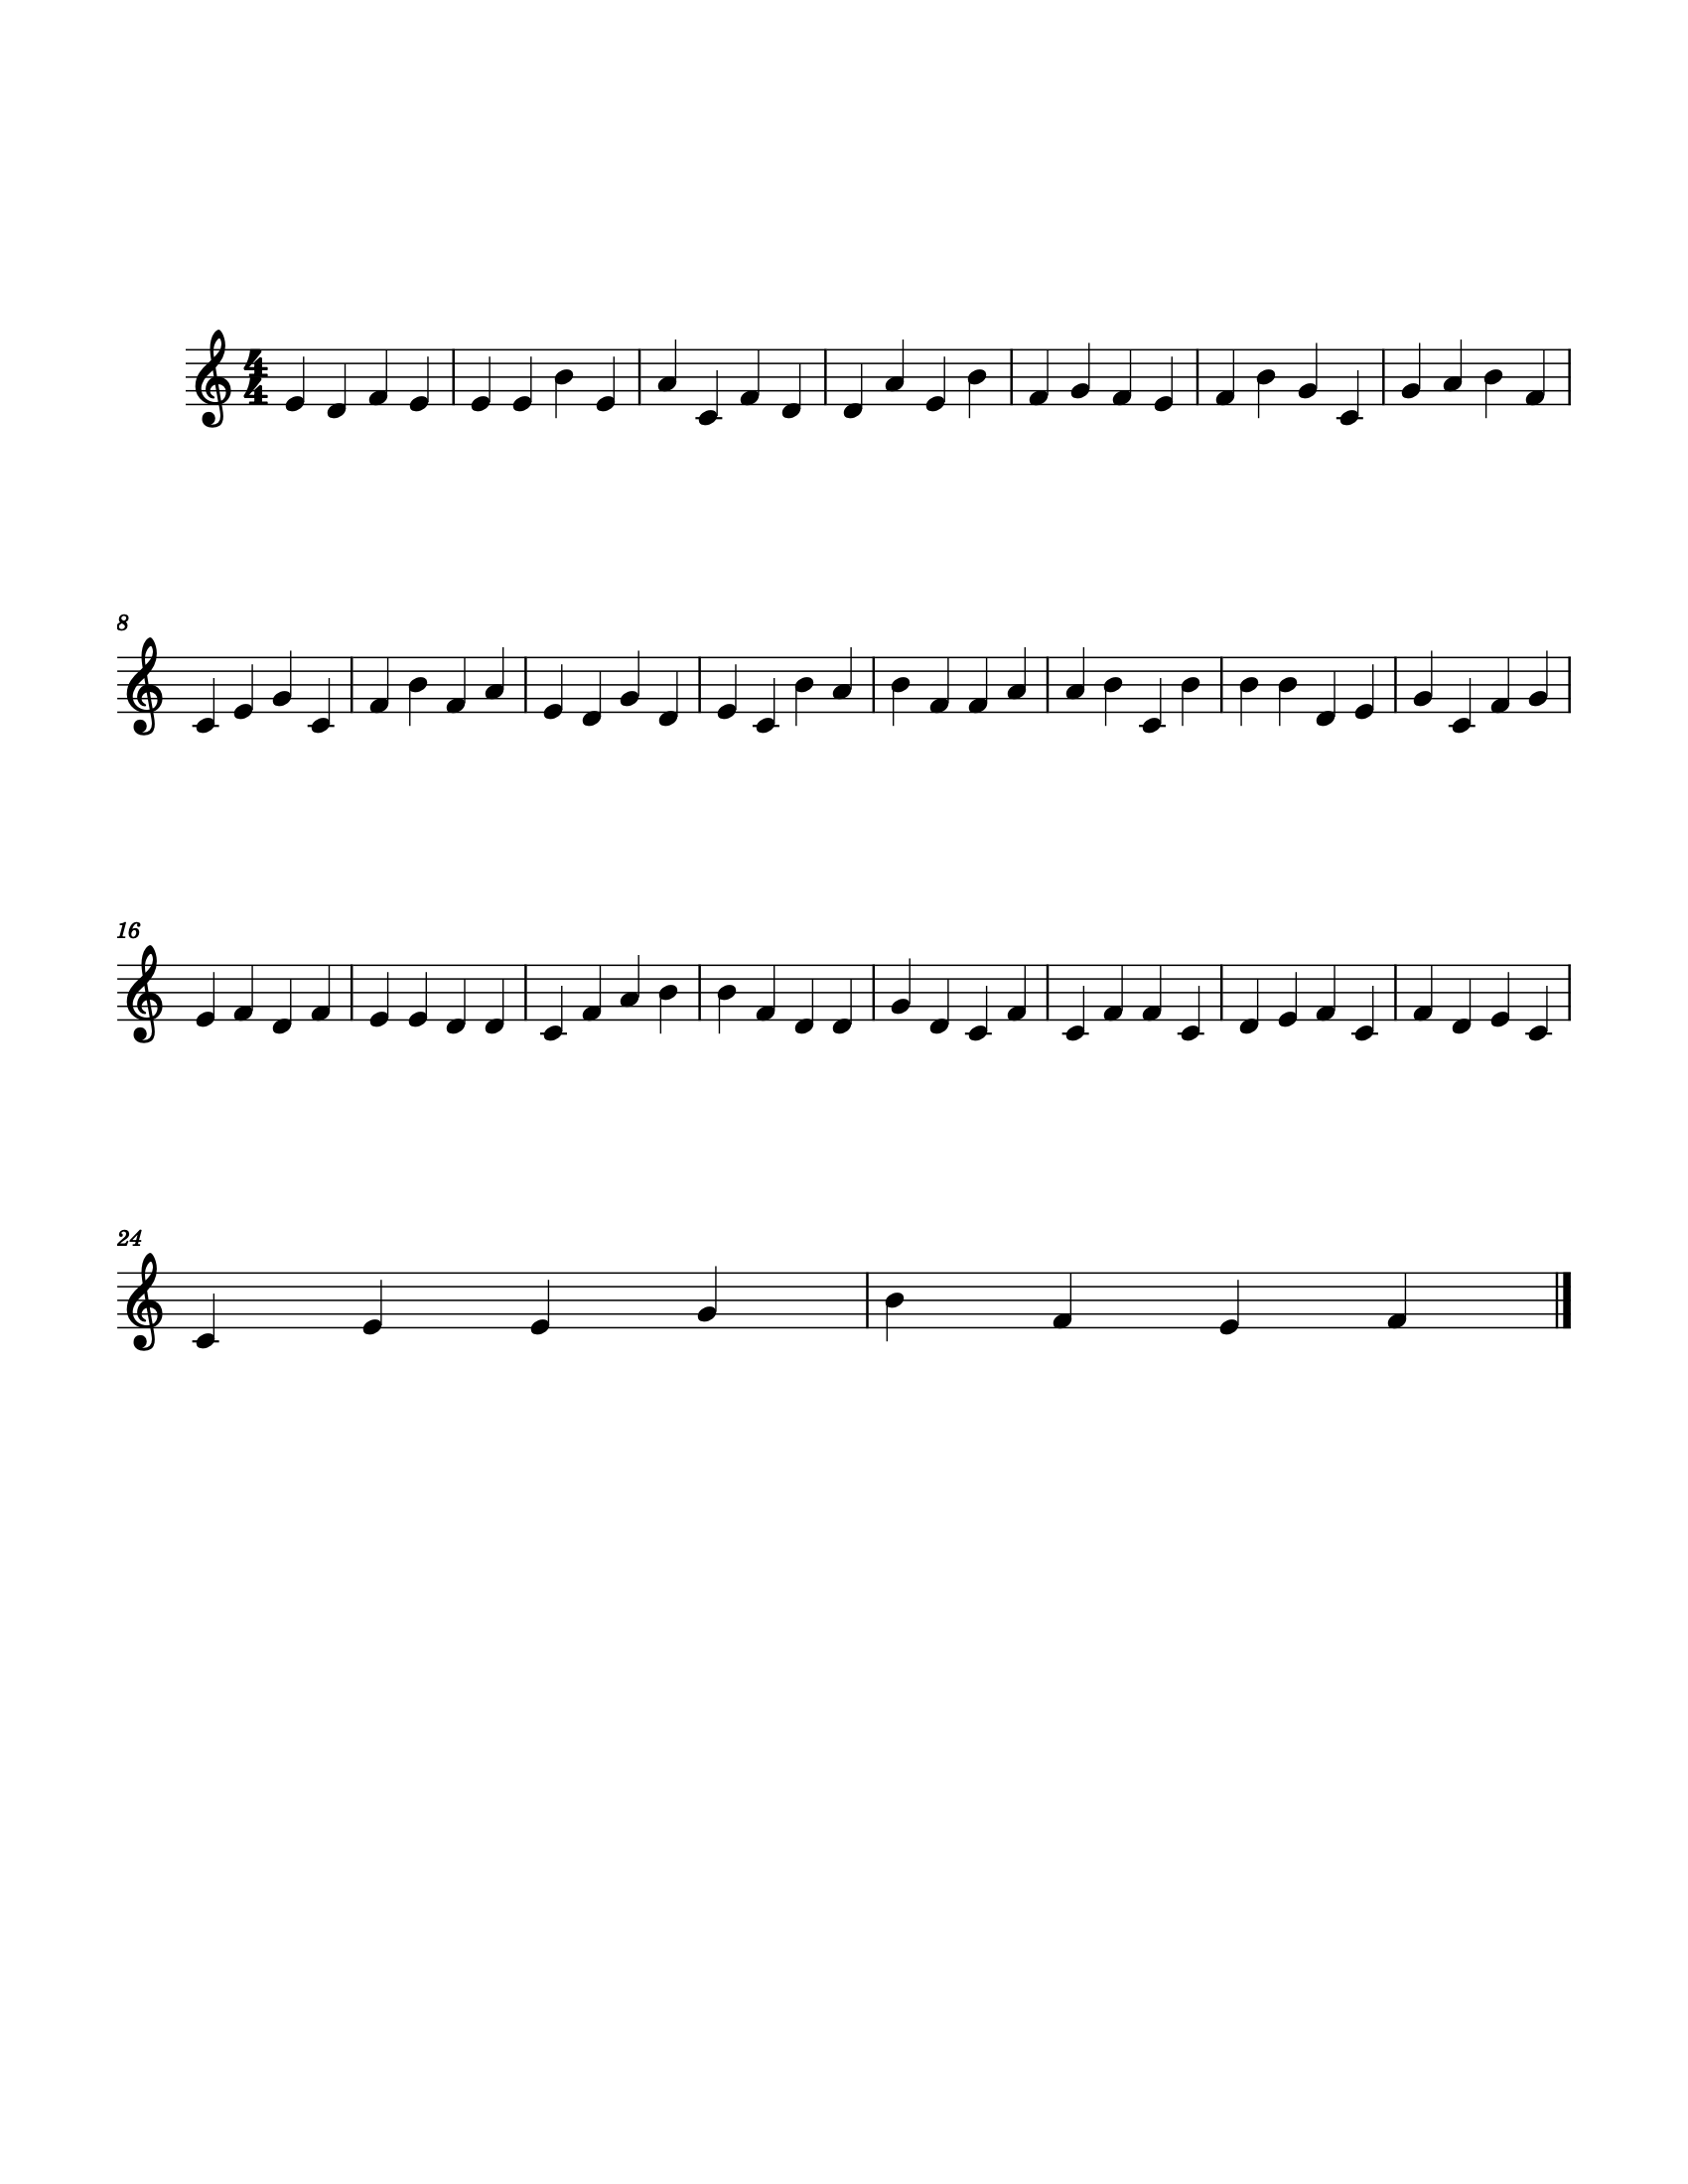

In [9]:
with open('objects/notes.pickle', 'rb') as f:
    notes = pickle.load(f)
    generated_music = get_music('objects/generator_model.h5', np.array(notes['pitch']))
    midi_gan = create_midi(generated_music, instrument.Violin())
    midi_gan.show('midi')
    midi_gan.show()